**Imports**

In [83]:
# Standard imports
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import trackpy as tp

from tqdm import tqdm  # for progress bar

import tensorflow as tf

**Read the data**

In [252]:
directory = 'Rec_EDGE_300K_1L_50MA.out'

data = pd.read_csv(directory + '/trajectories.csv')
data.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,0,24.420047,61.809992,33.895088,3.785002,0.048289,0.451671,91.250977,0.000493,0,0
1,1,31.518261,109.009463,33.850101,3.792741,0.067499,0.455270,91.282349,0.000493,0,1
2,2,51.658864,41.007417,34.208199,3.811746,0.062159,0.449871,92.517654,0.000486,0,2
3,3,60.994689,82.173861,34.559098,3.818268,0.046138,0.455270,93.368622,0.000482,0,3
4,4,61.572998,129.252586,33.747531,3.807508,0.059245,0.453470,91.835289,0.000490,0,4


**Drop the unused columns**

In [253]:
unused_columns = ['Unnamed: 0', 'mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep']

data = data.drop(columns=unused_columns)
data.head()

,y,x,frame,particle
0,24.420047,61.809992,0,0
1,31.518261,109.009463,0,1
2,51.658864,41.007417,0,2
3,60.994689,82.173861,0,3
4,61.572998,129.252586,0,4


**Fill in missing values with average positions (if a skyrmion is missing for more than one frame, it might not be very precise, but it should not be a big issue here)**

In [254]:
no_skyrmions = data[data['frame'] == 0].shape[0]
no_skyrmions

15

In [255]:
# ids of initial particles
ids = list(range(no_skyrmions))

# iterate through the frames
for f in tqdm(data['frame'].unique()):
    for p in range(no_skyrmions):
        # this means the skyrmion p is missing in frame f
        if not any(data[data['frame'] == f]['particle'] == p):
            
            # find previous coorinates
            x_prev = data[(data['frame'] == f-1) & (data['particle'] == p)]['x'].values[0]
            y_prev = data[(data['frame'] == f-1) & (data['particle'] == p)]['y'].values[0]
            
            x_next = x_prev
            y_next = y_prev
            
            #find next coordinates
            for next_frame in range((f+1).astype(int), len(data['frame'].unique())):
                if any(data[data['frame'] == f]['particle'] == p):
                    x_next = data[(data['frame'] == next_frame) & (data['particle'] == p)]['x'].values[0]
                    y_next = data[(data['frame'] == next_frame) & (data['particle'] == p)]['y'].values[0]
                    break
                    
            # new coordinates
            x_new = (x_prev + x_next) / 2
            y_new = (y_prev + y_next) / 2
            
            data = data.append({'y' : y_new,
                                'x' : x_new,
                                'frame' : f,
                                'particle': p}, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.35it/s]


In [256]:
data = data.sort_values(by=['frame', 'particle'])

In [257]:
data

,y,x,frame,particle
0,24.420047,61.809992,0.0,0.0
1,31.518261,109.009463,0.0,1.0
2,51.658864,41.007417,0.0,2.0
3,60.994689,82.173861,0.0,3.0
4,61.572998,129.252586,0.0,4.0
...,...,...,...,...
11922,26.838018,9158.734705,799.0,10.0
11927,92.153535,8909.539660,799.0,11.0
11935,160.675052,8812.401110,799.0,12.0
11934,156.663224,8600.194927,799.0,13.0


**Check that there are no more missing values**

In [258]:
for f in tqdm(data['frame'].unique()):
    if (data[data['frame'] == f]['particle'].shape[0] < no_skyrmions):
        print(f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 2804.36it/s]


**Put data in list**

In [259]:
no_skyrmions = int(max(data[data['frame'] == 0]['particle']) + 1)

# iterate through the frames
for f in tqdm(data['frame'].unique()):
    coordinates = None
    for p in data[data['frame'] == f]['particle']:
        particle = data[(data['frame'] == f) & (data['particle'] == p)]
        coordinates = np.append(coordinates, [particle['x'].values[0], particle['y'].values[0]]) if coordinates is not None else [particle['x'].values[0], particle['y'].values[0]]
    
    frames = np.append(frames, coordinates) if frames is not None else [coordinates]
                                                                        
frames = frames.reshape(-1, 2 * no_skyrmions)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 111.59it/s]


## One image input

**Make data samples**

In [295]:
# Samples are (frame, next_frame)

X = frames[:-1]
y = frames[1:]

**Split data for training and testing**

In [296]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [297]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (4162, 30)
y_train shape: (4162, 30)
X_test shape: (1041, 30)
y_test shape: (1041, 30)


**Hyperparameters**

In [412]:
activation = 'relu'

optimizer = 'NAdam'
loss = 'mae'
metrics = ['accuracy']
training_epochs = 500
batch_size = 64

n_input = 2 * no_skyrmions
n_hidden_1 = 64
n_hidden_2 = 64
n_hidden_3 = 64
n_output = 2 * no_skyrmions

**Build Neural Network**

In [413]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense

# Neural network
model = Sequential()
model.add(Dense(n_hidden_1, input_dim=n_input, activation=activation))
model.add(Dense(n_hidden_2, activation=activation))
model.add(Dense(n_hidden_3, activation=activation))
model.add(Dense(n_output))

In [414]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [415]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=training_epochs)

Train on 4162 samples, validate on 1041 samples
Epoch 1/500
4162/4162 [==============================] - 0s 72us/step - loss: 429.7657 - accuracy: 0.2124 - val_loss: 199.6942 - val_accuracy: 0.3247
Epoch 2/500
4162/4162 [==============================] - 0s 33us/step - loss: 126.4280 - accuracy: 0.4041 - val_loss: 112.4881 - val_accuracy: 0.3468
Epoch 3/500
4162/4162 [==============================] - 0s 34us/step - loss: 105.2713 - accuracy: 0.3936 - val_loss: 45.4507 - val_accuracy: 0.3064
Epoch 4/500
4162/4162 [==============================] - 0s 34us/step - loss: 103.8364 - accuracy: 0.4558 - val_loss: 152.0716 - val_accuracy: 0.3996
Epoch 5/500
4162/4162 [==============================] - 0s 36us/step - loss: 95.0313 - accuracy: 0.4476 - val_loss: 186.7882 - val_accuracy: 0.5850
Epoch 6/500
4162/4162 [==============================] - 0s 34us/step - loss: 92.5225 - accuracy: 0.4582 - val_loss: 178.8029 - val_accuracy: 0.2767
Epoch 7/500
4162/4162 [==============================] 

In [416]:
prediction = model.predict(X_test)
print(y_test[0])
print(prediction[0])

[7099.35379909  152.8009391  7055.49912764   94.17810036 6869.53299969
   21.49383797 7024.63037398  137.45235772 7112.42106543   32.43401849
 6777.40779964  170.6940966  6945.17644215   67.42483081 6861.49185377
  142.30558483 7169.39054552  112.56683038 6882.42292769  103.79689594
 7151.45255428   62.20181047 6990.43381748   49.68959532 6924.88548973
  162.55666357 6703.23842446  154.60617785 6810.46279301  124.42329158]
[7109.2163    170.8465   7048.865     112.136795 6862.1895      9.686163
 7017.297     149.08269  7098.982      16.141312 6779.196     185.49872
 6927.95       71.17219  6855.3545    169.88216  7173.2886     92.18815
 6877.538     115.31802  7170.343      76.9228   6980.4956     47.90226
 6943.186     132.50587  6691.6274    167.81882  6801.498     138.68045 ]


**Predict of test data**

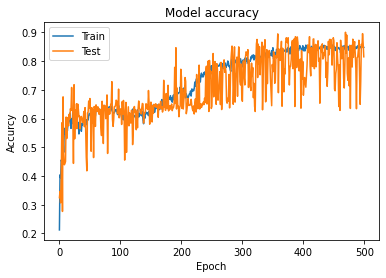

In [417]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accurcy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

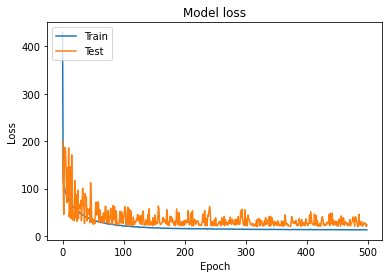

In [418]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## Two imges input

In [277]:
# Samples are ((frame, frame), next_frame)

X = None

for i in range(len(frames) - 2):
    X = np.append(X, np.append(frames[i], frames[i+1])) if X is not None else np.append(frames[i], frames[i+1])
X = X.reshape(-1, 4 * no_skyrmions)
y = frames[2:]

In [278]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [279]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (4161, 60)
y_train shape: (4161, 30)
X_test shape: (1041, 60)
y_test shape: (1041, 30)


In [280]:
activation = 'relu'

optimizer = 'NAdam'
loss = 'mae'
metrics = ['accuracy']
training_epochs = 250
batch_size = 128

n_input = 4 * no_skyrmions
n_hidden_1 = 512
n_hidden_2 = 256
n_hidden_3 = 128
n_output = 2 * no_skyrmions

In [281]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense

# Neural network
model = Sequential()
model.add(Dense(n_hidden_1, input_dim=n_input, activation=activation))
model.add(Dense(n_hidden_2, activation=activation))
model.add(Dense(n_hidden_3, activation=activation))
model.add(Dense(n_output))

In [282]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [192]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=training_epochs, batch_size=batch_size)

Train on 2881 samples, validate on 721 samples
Epoch 1/250
2881/2881 [==============================] - 0s 71us/step - loss: 858.1790 - accuracy: 0.0656 - val_loss: 427.5368 - val_accuracy: 0.0000e+00
Epoch 2/250
2881/2881 [==============================] - 0s 28us/step - loss: 381.3737 - accuracy: 0.1454 - val_loss: 251.7748 - val_accuracy: 0.3079
Epoch 3/250
2881/2881 [==============================] - 0s 28us/step - loss: 335.5894 - accuracy: 0.0312 - val_loss: 191.0637 - val_accuracy: 0.0236
Epoch 4/250
2881/2881 [==============================] - 0s 32us/step - loss: 284.6623 - accuracy: 0.1978 - val_loss: 315.5264 - val_accuracy: 0.0194
Epoch 5/250
2881/2881 [==============================] - 0s 29us/step - loss: 276.1798 - accuracy: 0.2326 - val_loss: 383.0871 - val_accuracy: 0.3384
Epoch 6/250
2881/2881 [==============================] - 0s 27us/step - loss: 258.2085 - accuracy: 0.2548 - val_loss: 127.9705 - val_accuracy: 0.0763
Epoch 7/250
2881/2881 [==========================

In [193]:
prediction = model.predict(X_test)
print(y_test[0])
print(prediction[0])

[8307.65818998  138.5996842  8215.5533698    58.79842978 8070.34314634
   55.55791575 8201.52035824  137.48486608 8286.44003785   64.81245699
 7947.61965135  175.39406315 8098.42546584   34.35981712 8050.50941845
  130.20741147 8374.50593301  135.6862201  7984.31161601  110.82733975
 8327.14487126   22.41812534 8167.65327501   35.70916312 8072.02552079
  156.94057174 7884.72049854  151.11977371 7944.2419176   105.50729335]
[8226.056     155.9529   8133.201      66.39265  7971.0044     33.816166
 8164.476     103.960144 8213.773      21.572456 7851.5767    138.4213
 8031.546      38.639545 7970.9243    128.02925  8294.385     107.067085
 7943.5537     98.74298  8282.372      20.356298 8093.6333     34.8546
 7990.798     161.96658  7821.744     148.9835   7877.813     103.53112 ]


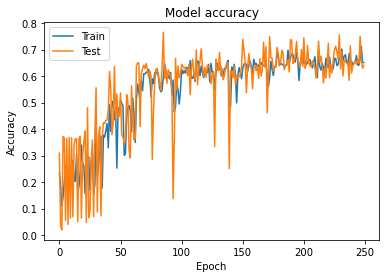

In [187]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

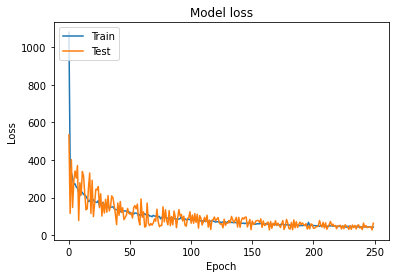

In [188]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## How are the results affected if I try to predict on using my prediction as input data? For how many rounds can this be accurate enough?

In [283]:
n = 50

# data in columns format (frame, next frame, next next frame, ...)
df_n_rounds = pd.DataFrame(columns=['X', 'y_1'])

for i in range(1, n):
    df_n_rounds['y_' + str(i+1)] = ''

for i in range(n+1):
    col = []
    for j in range(i, len(frames)-n+i):
        col.append(frames[j])
    if i == 0:
        df_n_rounds['X'] = col
    else:
        df_n_rounds['y_' + str(i)] = col

df_n_rounds

,X,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,...,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49,y_50
0,"[61.80999150562753, 24.420046719048628, 109.00...","[70.80009877085162, 22.786106233538195, 115.03...","[78.53846153846153, 23.79722075869336, 130.692...","[92.43681939593179, 22.50037668652832, 141.306...","[104.59782115297321, 22.04513325984048, 153.67...","[114.654700661428, 17.817739838317603, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...",...,"[548.3095747526077, 55.4499866274405, 542.7064...","[559.3591679425583, 54.50747056649596, 551.733...","[571.6816533108394, 56.70940531421341, 561.582...","[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995223, 624.534...","[645.4160783268949, 54.60836552550953, 632.508...","[655.4035507361932, 59.76984000425239, 648.778..."
1,"[70.80009877085162, 22.786106233538195, 115.03...","[78.53846153846153, 23.79722075869336, 130.692...","[92.43681939593179, 22.50037668652832, 141.306...","[104.59782115297321, 22.04513325984048, 153.67...","[114.654700661428, 17.817739838317603, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...","[175.51762512381282, 22.851074986890406, 214.4...",...,"[559.3591679425583, 54.50747056649596, 551.733...","[571.6816533108394, 56.70940531421341, 561.582...","[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995223, 624.534...","[645.4160783268949, 54.60836552550953, 632.508...","[655.4035507361932, 59.76984000425239, 648.778...","[664.2836707746479, 64.61612382629107, 654.376..."
2,"[78.53846153846153, 23.79722075869336, 130.692...","[92.43681939593179, 22.50037668652832, 141.306...","[104.59782115297321, 22.04513325984048, 153.67...","[114.654700661428, 17.817739838317603, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...","[175.51762512381282, 22.851074986890406, 214.4...","[187.1709068399876, 20.589291241101826, 222.27...",...,"[571.6816533108394, 56.70940531421341, 561.582...","[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995223, 624.534...","[645.4160783268949, 54.60836552550953, 632.508...","[655.4035507361932, 59.76984000425239, 648.778...","[664.2836707746479, 64.61612382629107, 654.376...","[681.5213026017112, 66.98795180722891, 667.341..."
3,"[92.43681939593179, 22.50037668652832, 141.306...","[104.59782115297321, 22.04513325984048, 153.67...","[114.654700661428, 17.817739838317603, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...","[175.51762512381282, 22.851074986890406, 214.4...","[187.1709068399876, 20.589291241101826, 222.27...","[204.5807988024767, 16.58671837790025, 232.493...",...,"[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995

In [284]:
from sklearn.model_selection import train_test_split

X = df_n_rounds['X'].tolist()
y = df_n_rounds['y_1'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [285]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [286]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (4123, 30)
y_train shape: (4123, 30)
X_test shape: (1031, 30)
y_test shape: (1031, 30)


In [287]:
activation = 'relu'

optimizer = 'NAdam'
loss = 'mae'
metrics = ['accuracy']
training_epochs = 1000
batch_size = 128

n_input = 2 * no_skyrmions
n_hidden_1 = 512
n_hidden_2 = 256
n_hidden_3 = 128
n_output = 2 * no_skyrmions

In [288]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense

# Neural network
model = Sequential()
model.add(Dense(n_hidden_1, input_dim=n_input, activation=activation))
model.add(Dense(n_hidden_2, activation=activation))
model.add(Dense(n_hidden_3, activation=activation))
model.add(Dense(n_output))

In [289]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [290]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=training_epochs, batch_size=batch_size)

Train on 4123 samples, validate on 1031 samples
Epoch 1/2000
4123/4123 [==============================] - 0s 56us/step - loss: 678.2435 - accuracy: 0.1227 - val_loss: 302.0640 - val_accuracy: 0.3492
Epoch 2/2000
4123/4123 [==============================] - 0s 26us/step - loss: 310.8763 - accuracy: 0.1072 - val_loss: 108.1657 - val_accuracy: 0.3492
Epoch 3/2000
4123/4123 [==============================] - 0s 25us/step - loss: 266.5346 - accuracy: 0.2033 - val_loss: 204.2677 - val_accuracy: 0.3463
Epoch 4/2000
4123/4123 [==============================] - 0s 25us/step - loss: 250.9102 - accuracy: 0.1484 - val_loss: 424.5764 - val_accuracy: 0.3346
Epoch 5/2000
4123/4123 [==============================] - 0s 24us/step - loss: 237.6068 - accuracy: 0.2008 - val_loss: 279.0913 - val_accuracy: 0.0436
Epoch 6/2000
4123/4123 [==============================] - 0s 25us/step - loss: 226.5152 - accuracy: 0.1722 - val_loss: 159.8997 - val_accuracy: 0.3511
Epoch 7/2000
4123/4123 [======================

In [291]:
prediction = model.predict(X_test)
print(y_test[0])
print(prediction[0])

[1751.76773078   84.47641139 1694.46276816   50.81048621 1618.58402303
   64.54566391 1767.68374248   60.84249749 1844.7595246    44.2053483
 1584.34925926  180.71388889 1666.16998469  123.59915773 1666.54179586
   82.07745365 1790.13368984  145.61377604 1610.11135997  113.62685899
 1773.43449872   33.07627471 1697.67095023   88.46600302 1715.23625897
  163.7135084  1506.10597983  156.43760036 1635.25868951  156.46682189]
[1754.5549     91.64721  1695.4012     51.62926  1620.1421     66.634186
 1769.8777     60.849033 1846.1808     39.312065 1598.3193    182.69206
 1668.8192    124.254974 1671.3055     86.821045 1793.9081    147.4376
 1619.6869    111.64371  1777.5789     31.942505 1699.1553     97.138
 1721.9653    165.9671   1513.5698    164.71869  1636.6245    158.32753 ]


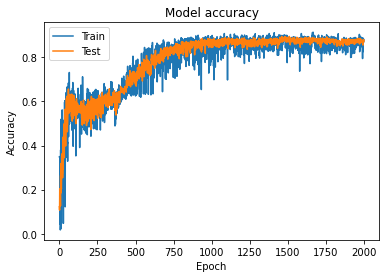

In [292]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

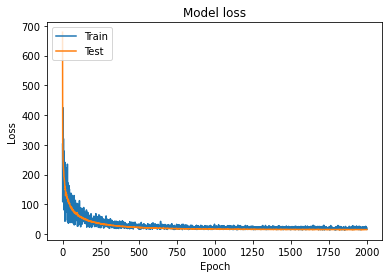

In [293]:
plt.plot(history.history['val_loss']) 
plt.plot(history.history['loss'])
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [294]:
from sklearn.metrics import mean_squared_error, r2_score

y_i_predict =  model.predict(np.array(X))
for i in range(1, n):
    y_i_predict = model.predict(y_i_predict)
    rmse = (np.sqrt(mean_squared_error(df_n_rounds['y_' + str(i+1)].tolist(), y_i_predict)))
    r2 = r2_score(df_n_rounds['y_' + str(i+1)].tolist(), y_i_predict)

    print("The model performance for y_{} -> y_{}".format(i, i+1))
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print("\n")

The model performance for y_1 -> y_2
--------------------------------------
RMSE is 282.7448210112196
R2 score is 0.8324789873154358


The model performance for y_2 -> y_3
--------------------------------------
RMSE is 347.23366007038794
R2 score is 0.6704590737926245


The model performance for y_3 -> y_4
--------------------------------------
RMSE is 401.9622510448943
R2 score is 0.4661864241475423


The model performance for y_4 -> y_5
--------------------------------------
RMSE is 450.56106878386277
R2 score is 0.22825854078079166


The model performance for y_5 -> y_6
--------------------------------------
RMSE is 494.8666270619463
R2 score is -0.049278203704609065


The model performance for y_6 -> y_7
--------------------------------------
RMSE is 536.0094140406396
R2 score is -0.3677914049323256


The model performance for y_7 -> y_8
--------------------------------------
RMSE is 574.612733854102
R2 score is -0.7107179197638236


The model performance for y_8 -> y_9
-----------